In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

读取图片

In [58]:
def load_image(image_path,tansform=None,max_size=None,shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size/max(image.size)
        size = np.array(image.size)*scale
        image = image.resize(size.astype(int),Image.ANTIALIAS)
        
    if shape:
        image = image.resize(shape,Image.LANCZOS)
    if transform:
        image = tansform(image).unsqueeze(0)
        
    return image.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

content = load_image("img/xian.JPG",transform,max_size=400)
style = load_image("img/star.jpg",transform,shape=[content.size(3),content.size(2)])

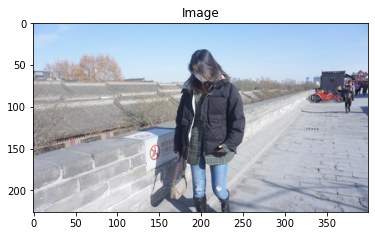

In [16]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(content[0], title='Image')
# content.shape

VGG net
我们用于提取style特征

In [59]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet,self).__init__()
        self.select = ['0','5','10','19','28']
        self.vgg = models.vgg19(pretrained=True).features
        
        
    def forward(self,x):
        features = []
        for name,layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

vgg = VGGNet().to(device).eval()

In [64]:
target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target],lr=0.03,betas=[0.5,0.999])
num_steps = 1000

for step in range(num_steps):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    content_loss = style_loss = 0.
    for f1,f2,f3 in zip(target_features,content_features,style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c,h,w = f1.size()
        f1 = f1.view(c,h*w) # [c,h*w]
        f3 = f3.view(c,h*w)#[c,h*w]
        
        f1 = torch.mm(f1,f1.t()) #[c,c]
        f3 = torch.mm(f3,f3.t()) #[c,c]
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
    loss = content_loss + style_loss*50.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step%100==0:
        print("Step [{}/{}],Content Loss:{:.4f} , Style Loss:{:.4f}".format(step,num_steps,content_loss.item(),style_loss.item()))
        
        

Step [0/1000],Content Loss:0.0000 , Style Loss:1035.3177
Step [100/1000],Content Loss:48.1512 , Style Loss:14.9233
Step [200/1000],Content Loss:51.3097 , Style Loss:7.5327
Step [300/1000],Content Loss:52.9896 , Style Loss:5.4746
Step [400/1000],Content Loss:52.5737 , Style Loss:4.4958
Step [500/1000],Content Loss:53.6466 , Style Loss:2.7754
Step [600/1000],Content Loss:53.8124 , Style Loss:3.0846
Step [700/1000],Content Loss:54.2035 , Style Loss:1.9909
Step [800/1000],Content Loss:54.1170 , Style Loss:1.7220
Step [900/1000],Content Loss:53.9883 , Style Loss:1.6212


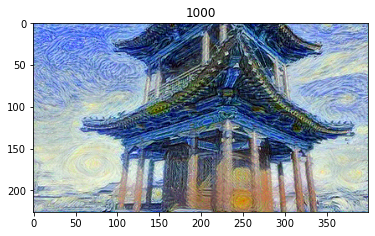

In [66]:
denorm = transforms.Normalize([-2.12,-2.04,-1.80],[4.37,4.46,4.44])
img = target.clone().squeeze()
img= denorm(img).clamp_(0,1)
imshow(img,title="1000")

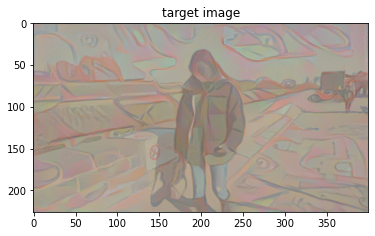

In [50]:
denorm = transforms.Normalize([-2.12,-2.04,-1.80],[4.37,4.46,4.44])
img = target.clone().squeeze()
img= denorm(img).clamp_(0,1)
imshow(img,title="target image")


In [20]:
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\stvea/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth


In [21]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [83]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                        std=(0.5, 0.5, 0.5))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

Part2: GAN

In [86]:
image_size = 3*28*28
hidden_size = 256

#Discriminate
D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

latent_size = 64
#Generate
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

D=D.to(device)
G=G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [89]:
total_steps = len(dataloader)
num_epochs = 30
for epoch in range(num_epochs):
    for i,(images,_) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size,image_size).to(device)
        
        real_labels = torch.ones(batch_size,1).to(device)
        fake_labels = torch.zeros(batch_size,1).to(device)
        
        #real 
        #when it comes D ,it better big
        outputs = D(images)
        d_loss_real = loss_fn(outputs,real_labels)
        real_score = outputs
        
        #fake
        z = torch.randn(batch_size,latent_size).to(device)#latent variable
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = loss_fn(outputs,fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        outputs = D(fake_images)
        g_loss = loss_fn(outputs,real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i %200 == 0:
            print("Epoch[{}/{}],Step [{}/{}], d_loss:{:.4f},g_loss:{:.4f},D(x):{:.2f},D(G(z)):{:.2f}"
                 .format(epoch,num_epochs,i,total_steps,d_loss.item(),g_loss.item(),
                          real_score.mean().item(),fake_score.mean().item()))

Epoch[0/30],Step [0/1875], d_loss:0.9516,g_loss:0.6802,D(x):0.79,D(G(z)):0.51
Epoch[0/30],Step [200/1875], d_loss:0.1602,g_loss:2.3996,D(x):0.99,D(G(z)):0.13
Epoch[0/30],Step [400/1875], d_loss:0.0049,g_loss:6.6093,D(x):1.00,D(G(z)):0.00
Epoch[0/30],Step [600/1875], d_loss:0.0060,g_loss:7.2489,D(x):1.00,D(G(z)):0.01
Epoch[0/30],Step [800/1875], d_loss:0.0021,g_loss:8.5323,D(x):1.00,D(G(z)):0.00
Epoch[0/30],Step [1000/1875], d_loss:0.0052,g_loss:6.2626,D(x):1.00,D(G(z)):0.00
Epoch[0/30],Step [1200/1875], d_loss:0.2911,g_loss:2.2803,D(x):1.00,D(G(z)):0.25
Epoch[0/30],Step [1400/1875], d_loss:0.0178,g_loss:5.0848,D(x):1.00,D(G(z)):0.01
Epoch[0/30],Step [1600/1875], d_loss:0.0247,g_loss:5.1341,D(x):0.99,D(G(z)):0.01
Epoch[0/30],Step [1800/1875], d_loss:0.1059,g_loss:5.5578,D(x):1.00,D(G(z)):0.08
Epoch[1/30],Step [0/1875], d_loss:0.0331,g_loss:7.2344,D(x):0.99,D(G(z)):0.02
Epoch[1/30],Step [200/1875], d_loss:0.1292,g_loss:3.8754,D(x):0.99,D(G(z)):0.11
Epoch[1/30],Step [400/1875], d_loss:0.0

Epoch[10/30],Step [400/1875], d_loss:0.1937,g_loss:4.5668,D(x):0.97,D(G(z)):0.11
Epoch[10/30],Step [600/1875], d_loss:0.0447,g_loss:7.8918,D(x):0.97,D(G(z)):0.01
Epoch[10/30],Step [800/1875], d_loss:0.1484,g_loss:3.3468,D(x):0.96,D(G(z)):0.07
Epoch[10/30],Step [1000/1875], d_loss:0.3305,g_loss:3.7567,D(x):0.86,D(G(z)):0.01
Epoch[10/30],Step [1200/1875], d_loss:0.1082,g_loss:7.2011,D(x):0.94,D(G(z)):0.02
Epoch[10/30],Step [1400/1875], d_loss:0.1146,g_loss:5.7588,D(x):0.99,D(G(z)):0.09
Epoch[10/30],Step [1600/1875], d_loss:0.2129,g_loss:4.5316,D(x):0.94,D(G(z)):0.06
Epoch[10/30],Step [1800/1875], d_loss:0.1910,g_loss:5.6923,D(x):0.98,D(G(z)):0.10
Epoch[11/30],Step [0/1875], d_loss:0.5308,g_loss:9.5745,D(x):0.88,D(G(z)):0.00
Epoch[11/30],Step [200/1875], d_loss:0.2432,g_loss:5.6373,D(x):0.92,D(G(z)):0.08
Epoch[11/30],Step [400/1875], d_loss:0.0876,g_loss:5.2369,D(x):0.94,D(G(z)):0.01
Epoch[11/30],Step [600/1875], d_loss:0.2843,g_loss:4.1572,D(x):0.88,D(G(z)):0.02
Epoch[11/30],Step [800/18

Epoch[20/30],Step [600/1875], d_loss:0.2281,g_loss:3.1549,D(x):0.96,D(G(z)):0.14
Epoch[20/30],Step [800/1875], d_loss:0.3113,g_loss:6.5560,D(x):0.87,D(G(z)):0.02
Epoch[20/30],Step [1000/1875], d_loss:0.1586,g_loss:4.8000,D(x):0.94,D(G(z)):0.07
Epoch[20/30],Step [1200/1875], d_loss:0.2417,g_loss:4.9909,D(x):0.96,D(G(z)):0.13
Epoch[20/30],Step [1400/1875], d_loss:0.4347,g_loss:2.3687,D(x):0.96,D(G(z)):0.26
Epoch[20/30],Step [1600/1875], d_loss:0.2465,g_loss:2.8875,D(x):0.89,D(G(z)):0.09
Epoch[20/30],Step [1800/1875], d_loss:0.4021,g_loss:2.1150,D(x):0.86,D(G(z)):0.15
Epoch[21/30],Step [0/1875], d_loss:0.2524,g_loss:3.9359,D(x):0.92,D(G(z)):0.11
Epoch[21/30],Step [200/1875], d_loss:0.3799,g_loss:2.8218,D(x):0.87,D(G(z)):0.15
Epoch[21/30],Step [400/1875], d_loss:0.4541,g_loss:2.6752,D(x):0.79,D(G(z)):0.06
Epoch[21/30],Step [600/1875], d_loss:0.2494,g_loss:4.1036,D(x):0.89,D(G(z)):0.06
Epoch[21/30],Step [800/1875], d_loss:0.2229,g_loss:4.3155,D(x):0.91,D(G(z)):0.08
Epoch[21/30],Step [1000/1

In [101]:
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)

In [102]:
fake_images = fake_images.view(batch_size,28,28,3).data.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


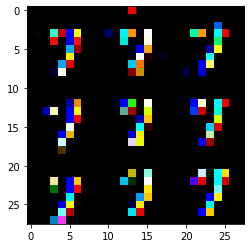

In [137]:
plt.imshow(fake_images[16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


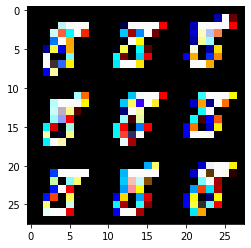

In [135]:
plt.imshow(images[0].view(28,28,3).data.cpu().numpy())